In [7]:
import gamspy as gp
import gamspy.math as gpm
from gamspy import Sum, Card, Container, Options, Problem, Sense

import sys
import numpy as np
import pandas as pd
import math
import itertools

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import contextily as ctx

options = Options(equation_listing_limit=0)
m = Container(options=options,debugging_level='keep')

In [8]:
drone = pd.read_csv("/home/samjenkins2001/CS524/Optimize/drone.csv")
loc = pd.read_csv("/home/samjenkins2001/CS524/Optimize/location.csv")

drone_df = pd.DataFrame(drone)
loc_df = pd.DataFrame(loc)

In [9]:
locations = list(loc_df["Location"])
models = list(drone_df["Drone Models"])
loc_df.index = locations
drone_df.index = models
loc_df = loc_df.drop(columns = "Location")
drone_df = drone_df.drop(columns = "Drone Models")
display(loc_df)
display(drone_df)

,Latitude,Longitude,Payload,Demand
Camp Randall,43.070227,-89.412687,10.0000,10 Footballs
Sam's Apartment,43.075462,-89.393407,2.6250,History of Optimization book
3006 Sunrise Ct,43.108656,-89.473928,5.0000,Bird Food
Kohl Center,43.069709,-89.396907,4.6875,5 New Basketball Jerseys
Computer Sciences Building,43.071286,-89.406561,6.1700,10 NVIDIA Jetsons
Noland Hall,43.071678,-89.404489,1.5000,4 cups of Pepper Seeds
Lake Mendota,43.107811,-89.419515,4.0000,Fishing Rod
The Kollege Klub,43.075951,-89.397279,11.2500,3 Bottles of NA Vodka
Tenney Park,43.092186,-89.367120,2.2000,Drinking Fountain Filter
The Bakke,43.076852,-89.420159,3.4500,5 BUCKS Pre Workout


,Carrying Capacity,Fly in Rain,Speed,Radius,Charging Current
MK30,5,1,80.47,32.1,840
MK27,5,0,80.47,16.1,560


In [14]:
## Must find a way to handle payloads greater than 5 lbs

# Haversine formula to calculate distance between two lat/long points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c

# Define depot and charging station
depot = {"DWI 4": (43.103263, -89.323598)}
sellery = {"Sellery": (43.075182, -89.400503)}

# Consumer locations with payload weights
locations = {
    "Camp Randall": (43.070227, -89.412687, 10.0000, 10),
    "Sam's Apartment": (43.075462, -89.393407, 2.6250, 1),
    "3006 Sunrise Ct": (43.108656, -89.473928, 5.0000, 1),
    "Kohl Center": (43.069709, -89.396907, 4.6875, 5),
    "Computer Sciences Building": (43.071286, -89.406561, 6.1700, 10),
    "Noland Hall": (43.071678, -89.404489, 1.5000, 4),
    "Lake Mendota": (43.107811, -89.419515, 4.0000, 1),
    "The Kollege Klub": (43.075951, -89.397279, 11.2500, 3),
    "Tenney Park": (43.092186, -89.367120, 2.2000, 1),
    "The Bakke": (43.076852, -89.420159, 3.4500, 5),
    "The Nick": (43.070881, -89.399039, 5.2000, 5),
    "Governer's Mansion": (43.113096, -89.370588, 0.7000, 1),
    "Wisconsin State Capital": (43.076583, -89.384819, 5.0000, 1),
    "Henry Vilas Zoo": (43.060791, -89.410046, 3.0000, 6),
    "The Edgewater": (43.079474, -89.389944, 3.4000, 7),
    "Nandini's Apartment": (43.069867, -89.394065, 2.6250, 1)
}

# Max initial ranges
initial_range_mk27 = 16.1
initial_range_mk30 = 32.1

# def get_possible_routes():
#     possible_routes = []

#     # Generate all subsets of consumers
#     consumers = list(locations.keys())
#     all_subsets = []
#     for r in range(1, len(consumers) + 1):
#         all_subsets.extend(itertools.combinations(consumers, r))

#     for subset in all_subsets:
#         # Calculate total payload
#         total_payload = sum(locations[consumer][2] for consumer in subset)

#         if total_payload > 5:
#             # Split into multiple runs (each with a maximum payload of 5 lbs)
#             remaining_payload = total_payload
#             subset_runs = []
#             while remaining_payload > 0:
#                 run_payload = min(5, remaining_payload)
#                 subset_runs.append((tuple(subset), run_payload))
#                 remaining_payload -= run_payload

#         # Only consider subsets with payload <= 5 lbs
#         if total_payload <= 5:
#             # Calculate distance for this subset (Depot -> Consumers -> Sellery)
#             total_distance = 0
#             all_consumer_coords = []
#             for consumer in subset:
#                 all_consumer_coords.append(locations[consumer][:2])

#             # Compute distances from Depot to Consumers
#             depot_lat, depot_lon = depot["DWI 4"]
#             for consumer_lat, consumer_lon in all_consumer_coords:
#                 total_distance += haversine(depot_lat, depot_lon, consumer_lat, consumer_lon)
#                 depot_lat, depot_lon = consumer_lat, consumer_lon  # Update the depot location after each consumer

#             # Add distance from last consumer to Sellery
#             sellery_lat, sellery_lon = sellery["Sellery"]
#             total_distance += haversine(depot_lat, depot_lon, sellery_lat, sellery_lon)

#             # Feasibility check (MK30 or MK27)
#             adjusted_range_mk30 = initial_range_mk30 * (1 - total_payload / 100)
#             adjusted_range_mk27 = initial_range_mk27 * (1 - total_payload / 100)

#             mk30_feasible = total_distance <= adjusted_range_mk30
#             mk27_feasible = total_distance <= adjusted_range_mk27

#             # Add feasible routes to the list
#             drone_type = None
#             if mk30_feasible and mk27_feasible:
#                 drone_type = "Both"
#             elif mk30_feasible:
#                 drone_type = "MK30"
#             elif mk27_feasible:
#                 drone_type = "MK27"

#             if drone_type:
#                 possible_routes.append({
#                     "Route": subset,
#                     "Payload (lbs)": total_payload,
#                     "Total Distance (km)": total_distance,
#                     "Drone Type": drone_type,
#                 })

#     return possible_routes

# # Get all possible routes
# routes = get_possible_routes()

# # Print the results
# routes_df = pd.DataFrame(routes)
# routes_df = routes_df.drop_duplicates(subset=["Route"], keep="first")
# display(routes_df)


In [22]:
def get_possible_routes():
    possible_routes = []
    unique_routes_set = set()  # To track unique routes by their items

    # Generate all subsets of consumers
    consumers = list(locations.keys())
    all_subsets = []
    for r in range(1, len(consumers) + 1):
        all_subsets.extend(itertools.combinations(consumers, r))

    for subset in all_subsets:
        total_payload = 0
        delivery_details = []  # Track item quantities delivered for each consumer
        remaining_capacity = 5  # Start with max payload capacity

        for consumer in subset:
            item_payload = locations[consumer][2] / locations[consumer][3]  # Payload per item
            max_items_for_location = min(
                locations[consumer][3], 
                int(remaining_capacity // item_payload)
            )
            
            if max_items_for_location > 0:
                delivered_payload = max_items_for_location * item_payload
                total_payload += delivered_payload
                remaining_capacity -= delivered_payload

                delivery_details.append((consumer, max_items_for_location))

        # Skip if no valid deliveries made or subset exceeds 5 lbs
        if total_payload == 0 or total_payload > 5:
            continue

        # Create a sorted representation of the delivery route to ensure uniqueness
        sorted_route = tuple(sorted(delivery_details))  # Sort the deliveries to prevent duplicates

        # If this sorted route has been seen before, skip it
        if sorted_route in unique_routes_set:
            continue
        unique_routes_set.add(sorted_route)

        # Calculate total distance for this subset (Depot -> Consumers -> Sellery)
        total_distance = 0
        depot_lat, depot_lon = depot["DWI 4"]

        for consumer, _ in delivery_details:
            consumer_lat, consumer_lon = locations[consumer][:2]
            total_distance += haversine(depot_lat, depot_lon, consumer_lat, consumer_lon)
            depot_lat, depot_lon = consumer_lat, consumer_lon  # Update last location to consumer

        sellery_lat, sellery_lon = sellery["Sellery"]
        total_distance += haversine(depot_lat, depot_lon, sellery_lat, sellery_lon)

        # Adjust for drone feasibility
        adjusted_range_mk30 = initial_range_mk30 * (1 - total_payload / 100)
        adjusted_range_mk27 = initial_range_mk27 * (1 - total_payload / 100)

        mk30_feasible = total_distance <= adjusted_range_mk30
        mk27_feasible = total_distance <= adjusted_range_mk27

        drone_type = None
        if mk30_feasible and mk27_feasible:
            drone_type = "Both"
        elif mk30_feasible:
            drone_type = "MK30"
        elif mk27_feasible:
            drone_type = "MK27"

        if drone_type:
            possible_routes.append({
                "Route": delivery_details,
                "Payload (lbs)": total_payload,
                "Total Distance (km)": total_distance,
                "Drone Type": drone_type,
            })

    return possible_routes

# Get all possible routes
routes = get_possible_routes()

# Convert to DataFrame and display
routes_df = pd.DataFrame(routes)
routes_df.to_csv('routes.csv', index=False)
display(routes_df)


,Route,Payload (lbs),Total Distance (km),Drone Type
0,"[(Camp Randall, 5)]",5.000000,9.246603,Both
1,"[(Sam's Apartment, 1)]",2.625000,7.034104,Both
2,"[(3006 Sunrise Ct, 1)]",5.000000,19.247534,MK30
3,"[(Kohl Center, 5)]",4.687500,7.700871,Both
4,"[(Computer Sciences Building, 8)]",4.936000,8.273510,Both
...,...,...,...,...
92,"[(Governer's Mansion, 1), (Henry Vilas Zoo, 6)...",4.671429,14.232382,Both
93,"[(Noland Hall, 4), (Tenney Park, 1), (The Bakk...",4.890000,19.621415,MK30
94,"[(Noland Hall, 4), (Tenney Park, 1), (The Bakk...",4.875714,19.330298,MK30
95,"[(Noland Hall, 4), (Tenney Park, 1), (Governer...",4.900000,22.005488,MK30


In [11]:
## Variables

s = m.addSet('s',description='Consumers',records=[i+1 for i in range(16)])
j = m.addSet('j',description='routes',records=['r'+str(i+1) for i in range(30)])
C = m.addSet('C',[s,j],description="customer covered by route",records=[
            ('2','r1'), ('2','r12'), ('2','r13'), ('2','r14'), ('2','r28'),
            ('3', 'r2'),
            ('4', 'r3'),
            ('6','r4'), ('6','r12'), ('6','r15'), ('6','r16'), ('6','r17'), ('6','r18'), ('6','r19'), ('6','r20'), ('6','r28'), ('6','r29'), ('6','r30'),
            ('7', 'r5'), ('7','r21'),
            ('9','r6'), ('9','r13'), ('9','r15'), ('9','r22'), ('9','r23'), ('9','r29'),
            ('10', 'r7'), ('10','r16'), ('10','r24'),
            ('12','r8'), ('12','r14'), ('12','r17'), ('12','r21'), ('12','r22'), ('12','r24'), ('12','r25'), ('12','r26'), ('12','r27'), ('12','r28'), ('12','r29'), ('12','r30'),
            ('14', 'r9'), ('14','r18'), ('14','r25'),
            ('15', 'r10'), ('15','r19'), ('15','r26'),
            ('16','r11'), ('16','r20'), ('16','r23'), ('16','r27'), ('16','r30')
])
# Number of MK30 Drones used
# Number of MK27 Drones used
x = m.addVariable('x','binary',domain=[j])

cover = m.addEquation('cover',domain=[s])
cover[s]= Sum(C[s,j], x[j]) >= 1

setcover = m.addModel('setcover',
    equations=m.getEquations(),
    problem=Problem.MIP,
    sense=Sense.MIN,
    objective=Sum(j, x[j]),
)

setcover.solve(output=None,options=Options(absolute_optimality_gap=0.999))
display(x.records)

# Amount of charge used on MK30 Drones (Wh)
# Amount of charge used on MK27 Drones (Wh)

#Battery Percentage for each drone

GamspyException: There was an execution error. Check /tmp/tmpnr0xia5j/_3d7111cc-f17a-4101-a5af-37de811510f1.lst for more information.

=============
Error Summary
=============

**** Exec Error at line 38: Equation infeasible due to rhs value

**** INFEASIBLE EQUATIONS ...

---- cover  =G=  

cover(1)..  0 =G= 1 ; (LHS = 0, INFES = 1 ****)
     
cover(5)..  0 =G= 1 ; (LHS = 0, INFES = 1 ****)
     
cover(8)..  0 =G= 1 ; (LHS = 0, INFES = 1 ****)
     
cover(11)..  0 =G= 1 ; (LHS = 0, INFES = 1 ****)
     
cover(13)..  0 =G= 1 ; (LHS = 0, INFES = 1 ****)

In [ ]:
## Optimization Model

## Objective
# Minimize Energy Consumption

## Payload Constraint
# Each Drone <= 5 lbs

## Speed Constraint
# Each Drone <= 80.47 km / hr

## Weather Constraint
# If rain, only MK 30 Drones

## Range Constraint
# Ensure each drone returns to charging stations with non-zero battery life

## Charge Constraint
# Ensure each drone cannot be charged > 100%

## Item Constraint
# Ensure Drone only delivers whole items (ie. multiples of 0.5 lbs to the zoo for each animal slipper)

In [ ]:
## Pareto Curve showing Tradeoff between Energy Consumption and Delivery Time

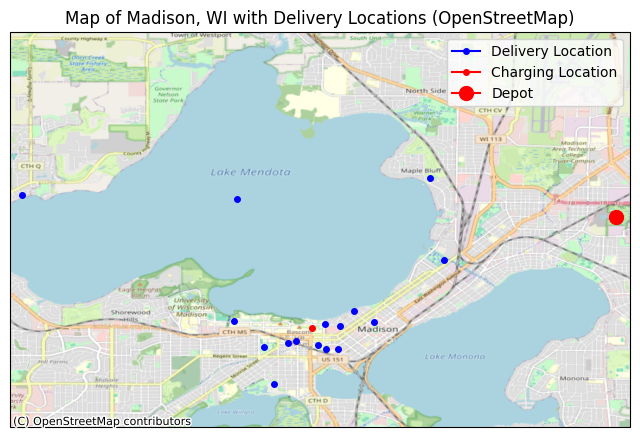

In [ ]:
latitudes = list(loc_df["Latitude"])
longitudes = list(loc_df["Longitude"])

coordinates = list(zip(latitudes, longitudes))

delivery_coords = coordinates[:-2]
charge_coords = coordinates[-2:]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([-89.477, -89.32, 43.05, 43.15], crs=ccrs.PlateCarree())

ctx.add_basemap(ax, crs=ccrs.PlateCarree(), source=ctx.providers.OpenStreetMap.Mapnik)

for coord in delivery_coords:
    latitude = coord[0]
    longitude = coord[1]
    ax.plot(longitude, latitude, marker='o', color='blue', markersize=4, transform=ccrs.PlateCarree(), label="Delivery Location" if coord == delivery_coords[0] else "")

for coord in charge_coords:
    latitude = coord[0]
    longitude = coord[1]
    ax.plot(longitude, latitude, marker='o', color='red', markersize=4 if coord == charge_coords[0] else 10, transform=ccrs.PlateCarree(), label="Charging Location" if coord == charge_coords[0] else "Depot")

plt.legend()

plt.title("Map of Madison, WI with Delivery Locations (OpenStreetMap)")

plt.show()


